### Task
В данном задании необходимо обучить агента побеждать в игре Walker2D при помощи Actor-Critic, A2C, TRPO или PPO. Для решения задачи можно трансформировать состояние и награду среды.

К заданию также нужно приложить код обучения агента (не забудьте зафиксировать seed!), готовый (уже обученный) агент должен быть описан в классе Agent в файле 'agent.py'.

Обратите внимание: для выполнения данной работы вам потребуется установить библиотеку PyBullet.

<a href='https://wandb.ai/cleanrl/cleanrl.benchmark/runs/15j9uuia/files/code/cleanrl/ppo_continuous_action.py'>Статья</a>

In [1]:
from gym import make
import gym
import numpy as np
import torch
from torch import nn
from torch.distributions import Normal
from torch.nn import functional as F
from torch.optim import Adam
import base64, io
import matplotlib.pyplot as plt
import pybullet_envs
import random

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob

import warnings
warnings.filterwarnings('ignore')

/Users/annasmelova/anaconda3/envs/made_rl/lib/python3.9/site-packages/gym/envs/registration.py:440: UserWarning: WARN: The `registry.env_specs` property along with `EnvSpecTree` is deprecated. Please use `registry` directly as a dictionary instead.
  logger.warn(


In [2]:
SEED = 1
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
ENV_NAME = "Walker2DBulletEnv-v0"

In [4]:
import train as t
import agent as a

In [5]:
%%time
rewards, lrs, steps = t.main()

pybullet build time: Nov 11 2022 15:18:46


Step: 10, Reward mean: 48.8636278380279, Reward std: 37.300771715702275 | Episodes: 992, Steps: 20564, LR: 0.00029759999999999997
Step: 20, Reward mean: 61.04455157115997, Reward std: 7.86332473731596 | Episodes: 1261, Steps: 41283, LR: 0.00029459999999999995
Step: 30, Reward mean: 68.70532161736251, Reward std: 11.217915050511632 | Episodes: 1515, Steps: 62331, LR: 0.0002916
Step: 40, Reward mean: 56.06841928745621, Reward std: 14.22602041844267 | Episodes: 1796, Steps: 83452, LR: 0.00028859999999999997
Step: 50, Reward mean: 65.68390438989213, Reward std: 25.82770008413014 | Episodes: 2048, Steps: 104544, LR: 0.00028559999999999995
Step: 60, Reward mean: 79.14934115062002, Reward std: 29.948614550256384 | Episodes: 2293, Steps: 125376, LR: 0.0002826
Step: 70, Reward mean: 53.129518541832226, Reward std: 31.62509979561107 | Episodes: 2528, Steps: 146362, LR: 0.00027959999999999997
Step: 80, Reward mean: 119.97916046846164, Reward std: 33.2513479411588 | Episodes: 2732, Steps: 167669, 

Step: 650, Reward mean: 620.6631120428158, Reward std: 594.2078646796595 | Episodes: 5687, Steps: 1773586, LR: 0.00010559999999999998
Step: 660, Reward mean: 1351.7711730962048, Reward std: 17.82178719284876 | Episodes: 5728, Steps: 1807043, LR: 0.00010259999999999999
Step: 670, Reward mean: 1259.165369954057, Reward std: 112.5304807270437 | Episodes: 5768, Steps: 1843464, LR: 9.959999999999998e-05
Step: 680, Reward mean: 1365.5172385271212, Reward std: 14.17141214962686 | Episodes: 5809, Steps: 1878828, LR: 9.659999999999998e-05
Step: 690, Reward mean: 845.7890567973797, Reward std: 634.8981602501146 | Episodes: 5849, Steps: 1917031, LR: 9.360000000000001e-05
Step: 700, Reward mean: 1351.2649796446176, Reward std: 40.09619289592065 | Episodes: 5891, Steps: 1950168, LR: 9.06e-05
Step: 710, Reward mean: 1127.2678393259444, Reward std: 547.4714010079123 | Episodes: 5931, Steps: 1978989, LR: 8.76e-05
Step: 720, Reward mean: 1131.5836640809198, Reward std: 550.6211148837097 | Episodes: 597

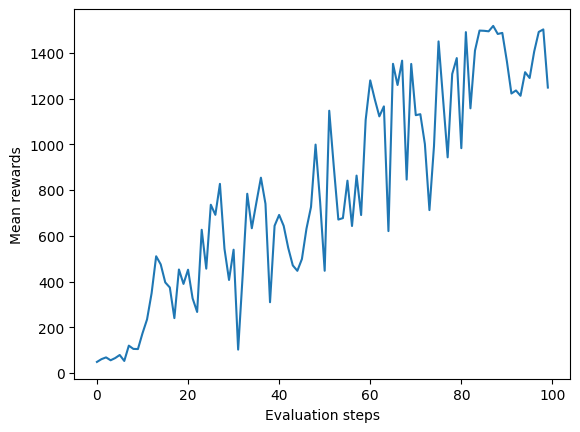

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(rewards)), rewards)
plt.ylabel('Mean rewards')
plt.xlabel('Evaluation steps')
plt.show()

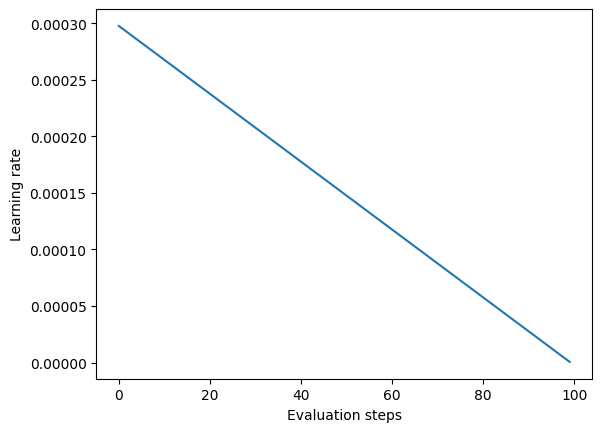

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(lrs)), lrs)
plt.ylabel('Learning rate')
plt.xlabel('Evaluation steps')
plt.show()

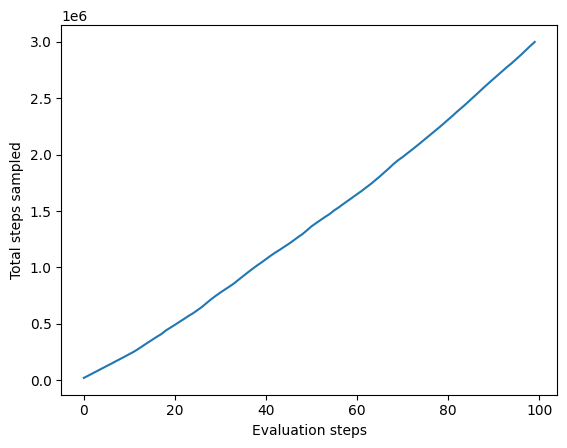

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(steps)), steps)
plt.ylabel('Total steps sampled')
plt.xlabel('Evaluation steps')
plt.show()

In [9]:
def show_video(env_name, tag='best'):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = f'video/{env_name}_{tag}.mp4'
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data=''''''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")
        
def show_video_of_model(agent, env_name, tag='best'):
    env = gym.make(env_name)
    vid = video_recorder.VideoRecorder(env, path=f"video/{env_name}_{tag}.mp4")
    agent.load_state_dict(torch.load(f'checkpoint_{tag}.pth'))
    state = env.reset()
    done = False
    while not done:
        frame = env.render()
        vid.capture_frame()
        action = agent.act(state)

        state, reward, done, _ = env.step(action)        
    env.close()

In [10]:
agent = a.Agent()
show_video_of_model(agent, ENV_NAME,'first')

In [11]:
show_video(ENV_NAME,'first')

In [12]:
agent = a.Agent()
show_video_of_model(agent, ENV_NAME,'best')

In [13]:
show_video(ENV_NAME,'best')

In [14]:
def evaluate_policy(env, agent, episodes=5):
    returns = []
    for _ in range(episodes):
        done = False
        state = env.reset()
        total_reward = 0.
        
        while not done:
            state, reward, done, _ = env.step(agent.act(state)[0])
            total_reward += reward
        returns.append(total_reward)
    return returns

In [15]:
env = make(ENV_NAME)
ppo = t.PPO(state_dim=env.observation_space.shape[0], action_dim=env.action_space.shape[0])
ppo.actor.load_state_dict(torch.load("agent.pkl"))
returns_check = evaluate_policy(env, ppo, episodes=50)

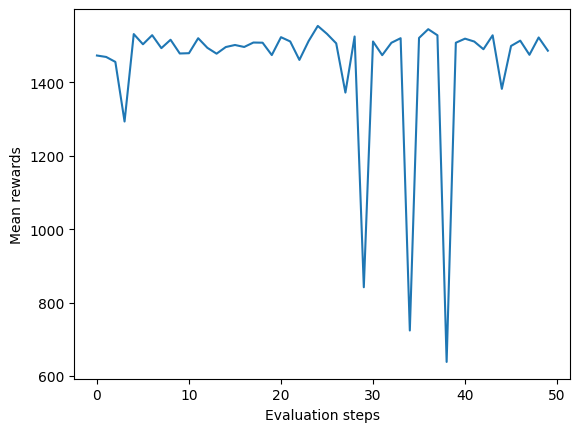

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(returns_check)), returns_check)
plt.ylabel('Mean rewards')
plt.xlabel('Evaluation steps')
plt.show()

In [17]:
print(f'Mean rewards by 50 episodes: {np.mean(returns_check)}')

Mean rewards by 50 episodes: 1449.2403998976765
